# Installation

In [ ]:
# Install pyBigWig with conda to take the libcurl dependencies into account
! conda install pybigwig -c conda-forge -c bioconda
! pip install keras_dna

In [1]:
from keras_dna import Generator, ModelWrapper, MultiGenerator
import tensorflow.keras as keras

In [1]:
from keras_dna.sequence import SeqIntervalDl, StringSeqIntervalDl
import os

# Regression problem

To experiment the possible usage of `keras_dna` in the context of regression, we will train a neural network to predict the nucleosome density in $\textit{S.cerevisiae}$ directly from the DNA sequence.

#### Downloading the data

The data needed are :
- the DNA sequence in a fasta file.
- an experimental nucleosome coverage in bigwig format.

In [ ]:
!mkdir tutorial_dr
os.chdir('tutorial_dr')

!wget http://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.fa.gz
!gunzip sacCer3.fa
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0010101/Saccharomyces_cerevisiae.scNuc0010101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0010101.nucleosome.shift.bw scerevisiae.bw

#### Building a 1d CNN with keras

We build a 1d convolutionnal network with three convolutionnal layers. The model will be trained to predict the nucleosome density at the center of a 2001 bp DNA window. 
The model input shape is (batch_size, 2001, 4). The outputs are of shape (batch_size, 1).

In [ ]:
from keras_dna import Generator, ModelWrapper, MultiGenerator
import tensorflow.keras as keras

model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='linear'))
          
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=10,
                                      verbose=0,
                                      mode='auto')

generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

In [4]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='linear'))
          
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [5]:
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=10,
                                      verbose=0,
                                      mode='auto')

### Train the model

We use `Generator` class to feed our model with the training data. One needs to pass the DNA sequence in a fasta file, the nucleosome density in bigwig. One needs to specify the batch size (here 64) and the length of the input required by the network (2001 bp).

In this example we restrict our train set to the 6 first chromosomes and the output_shape is specified to correspond to the model output.

In [3]:
os.chdir('./tutorial_dr/')

In [11]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 1))

We can now associate the model to its specific train generator in a `ModelWrapper` instance. In this case we will also associate another `Generator` to our model : the validation generator. This generator is used in the validation process and yields data coming from chromosome 7 and 8.

In [7]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

Use `train` method to train the model. One can also pass arguments that will be used by the keras model method [fit_generator](https://keras.io/models/sequential/)

In [9]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

Evaluation can be made on a new chromosome with the method `evaluate`. Arguments corresponding to the keras model method [evaluate_generator](https://keras.io/models/sequential/) can be passed.

In [8]:
wrap.evaluate(incl_chromosomes=['chrM'], verbose=1)

1309/1309 [==============================] - 83s 64ms/step - loss: 47.2756 - mae: 1.2058


[47.275604481257446, 1.2057654]

We can also specificaly calculate the correlation between the predicted and experimental nucleosome density. Use the method `get_correlation` to do so. It also use internally the evaluate_generator keras method.

In [ ]:
wrap.get_correlation(incl_chromosomes=['chrM'], verbose=1)

#### Normalization of the inputs

As nucleosome density is an experimental data, one needs to normalize it for comparison purpose. It is also a good practise to remove outliers before calculating any metrics. Here we will cut the distribution to the last percentile and divide by the new maximum.

To do so we use the keyword normalization_mode.

In [10]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 1))

The available normalization are: 

- max : dividing by the maximum
- perctrim: trimming the distribution to the last percentile
- zscore
- min_max 

Two consecutive normalizations can be applied, in the example perctrim is applied before max.

In [11]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [8]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

In [ ]:
wrap.evaluate(incl_chromosomes=['chrIX'], verbose=1)

In [10]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

#### Adding weights to balance the training process

The distribution of the nucleosome density is not flat, it means that rare score will tend to be ill predicted by the model because they account for virtually nothing in the loss function. To compensate this fact an usual strategy is to add weights during the training for the loss calculation.

To balance the relative importance of scores one can pass 'balanced' to the weighting_mode keyword.

In [24]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            weighting_mode='balanced',
                            output_shape=(64, 1))

Set the keyword weights_val to specify that one wants to apply the weights to calculate metrics on the validation set.

In [11]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'],
                    weights_val=True)

In [13]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

During the evaluation process one can specify if one wants to include weights with the keyword weights_eval.

In [26]:
wrap.evaluate(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

In [16]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

#### Helper function to create a `Generator`

In this section we saw how to build a `Generator` instance that generates data with a shape adapted to the model at hand. We present here some class method that enable to test the shape of the data generated before creating the `Generator` instance. We can play with the keywords to adapt the shape to our needs, note that the shape is returned without the batch_size axis.

First, let's look at the input shape with the class method `predict_input_shape`. The keyword dummy_axis and alphabet_axis enable to adapt the shape of the input data.

In [24]:
Generator.predict_input_shape(batch_size=64,
                              fasta_file='sacCer3.fa',
                              annotation_files=['scerevisiae.bw'],
                              window=2001,
                              dummy_axis=1,
                              alphabet_axis=2,
                              incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                              output_shape=(64, 1))

(2001, 1, 4)

We can now look at the label shape by using the class method `predict_label_shape`. The useful keyword to change the label shape are:

- the number of file passed through annotation_files
- nb_annotation_type
- tg_window
- output_shape

The tutorial will present how to use those keywords but you can play here to get an insight of how the label shape is organised.

In [36]:
Generator.predict_label_shape(batch_size=64,
                              fasta_file='sacCer3.fa',
                              annotation_files=['scerevisiae.bw', 'scerevisiae.bw', 'scerevisiae.bw', 'scerevisiae.bw'],
                              window=2001,
                              tg_window=10,
                              nb_annotation_type=2,
                              output_shape=None,
                              incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'])

(10, 2, 2)

### Saving model

The `ModelWrapper` instance can be saved in a hdf5 file with the method `save`.

Be aware, as it is usual to save the best model obtained during the training process (with the keras callbacks [ModelCheckpoint](https://keras.io/callbacks/)), one may  want not to overwrite the model at the end of training.
To prevent the method from overwritting the model, set the keyword save_model to False (default behaviour).

In [17]:
wrap.save('./weights_CNN_nucleosome_normalized_weighted.hdf5',
          save_model=True)

### Loading a `ModelWrapper` instance

In [4]:
from keras_dna.model import load_wrapper, load_generator_command

First situation, one wants to reuse a `ModelWrapper` instance and to reuse both the model and the data, furthermore the path to access the data is unchanged since saving time.  

The method `load_wrapper` loads both the model and the generator with the original data, the path to access data must therefore be unchanged.

In [5]:
wrapper = load_wrapper('./weights_CNN_nucleosome_normalized_weighted.hdf5')

We can work with the loaded instance as usual.

In [20]:
wrapper.get_correlation(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

Second situtation, we want to reuse the model contained in a saved `ModelWrapper` instance but with new data (or just because their localisation has changed since saving). The module `load_generator_command`returns a tuple of dictionaries that can be used to recreate the training and validation generators.

As an exemple we will reuse our saved model and train it on a new experimental nucleosome density (transfer learning).

First, we downlaod the new data.

In [8]:
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0020101/Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw scerevisiae2.bw

--2020-07-23 10:00:50--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0020101/Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2525167 (2.4M) [text/plain]
Sauvegarde en : « Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw »

Saccharomyces_cerev 100%[===================>]   2.41M   895KB/s    ds 2.8s    

2020-07-23 10:00:53 (895 KB/s) — « Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw » sauvegardé [2525167/2525167]



Then, we load the dictionaries to see how to create train and validation generators adapted to the model with the method `load_generator_command`.

In [29]:
command_train, command_val = load_generator_command('./weights_CNN_nucleosome_normalized_weighted.hdf5')
command_train

{'type': 'Generator',
 'arguments': {'batch_size': 64,
  'one_hot_encoding': True,
  'output_shape': [64, 1],
  'weighting_mode': 'balanced',
  'bins': 'auto',
  'fasta_file': 'sacCer3.fa',
  'annotation_files': ['scerevisiae.bw'],
  'window': 2001,
  'normalization_mode': ['max', 'perctrim'],
  'incl_chromosomes': ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI']}}

Then, load the model with the keras method `load_model`.

In [25]:
model = keras.models.load_model('./weights_CNN_nucleosome_normalized_weighted.hdf5')

Change the name of the bigwig file in the dictionnary.

In [30]:
command_train = command_train['arguments']
command_val = command_val['arguments']

command_train['annotation_files'] = ['scerevisiae2.bw']
command_val['annotation_files'] = ['scerevisiae2.bw']
command_train

{'batch_size': 64,
 'one_hot_encoding': True,
 'output_shape': [64, 1],
 'weighting_mode': 'balanced',
 'bins': 'auto',
 'fasta_file': 'sacCer3.fa',
 'annotation_files': ['scerevisiae2.bw'],
 'window': 2001,
 'normalization_mode': ['max', 'perctrim'],
 'incl_chromosomes': ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI']}

Create new `Generator` instances that will match the model needs but with new data. We can then create a `ModelWrapper` instance to associate the model to its new training data.

In [31]:
generator_train = Generator(**command_train)
generator_val = Generator(**command_val)

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    generator_val=generator_val)

Then, we can train the model on new data (transfer learning).

In [34]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

To evaluate a model on new data the module `get_correlation` owns keywords to do so without the need of recreating totally new generators by hand (not `evaluate`).

For example, say we want to evaluate if our model trained on S.cerevisiae is able to predict the nucleosome density on C.elegans. We will download the C.elegans genome as well as an experimental nucleosome density and calculate the correlation between the predicted density and the experimental one.

In [7]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.fa.gz
!gunzip ce11.fa.gz
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Caenorhabditis_elegans/bySample/ceNuc0010101/Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw
!mv Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw celegans.bw

--2020-05-01 14:39:24--  https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.fa.gz
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 31816111 (30M) [application/x-gzip]
Sauvegarde en : « ce11.fa.gz »

ce11.fa.gz          100%[===================>]  30.34M  8.44MB/s    ds 6.8s    

2020-05-01 14:39:32 (4.47 MB/s) — « ce11.fa.gz » sauvegardé [31816111/31816111]

gzip: cell.fa.gz: No such file or directory
--2020-05-01 14:39:32--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Caenorhabditis_elegans/bySample/ceNuc0010101/Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 19735260 (19M) 

One needs to pass the fasta file as well as the bigwig file to the `get_correlation` method.

In [5]:
wrap.get_correlation(incl_chromosomes=['chrM'],
                     fasta_file='ce11.fa',
                     annotation_files=['celegans.bw'],
                     verbose=1)

184/184 [==============================] - 13s 72ms/step - loss: 66987.2414 - metric: 0.0211


{'correlate_0_0': 0.021094829}

### Prediction on a full chromosomes

Use the method `predict` to predict the nucleosome density on full chromosomes, this prediction can be exported as bigwig files (if a path is passed as argument). One needs to pass a file with chromosome size in two columns tab separated to the method, its name should end with .chrom.sizes.

In [3]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes

--2020-11-23 17:00:55--  https://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 229 [text/plain]
Sauvegarde en : « sacCer3.chrom.sizes »

sacCer3.chrom.sizes 100%[===================>]     229  --.-KB/s    ds 0s      

2020-11-23 17:00:56 (6.80 MB/s) — « sacCer3.chrom.sizes » sauvegardé [229/229]



In [6]:
prediction = wrap.predict(incl_chromosomes=['chrIX', 'chrX'],
                          chrom_size='sacCer3.chrom.sizes',
                          export_to_path='prediction_chrIX_chrX.bw',
                          verbose=1)

36926/36926 [==============================] - 1010s 27ms/step


We can also predict on a different genome for example C.elegans with the model trained on S.cerevisiae.

In [13]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.chrom.sizes

--2020-05-01 14:42:28--  https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 99 [text/plain]
Sauvegarde en : « ce11.chrom.sizes »

ce11.chrom.sizes    100%[===================>]      99  --.-KB/s    ds 0s      

2020-05-01 14:42:29 (3.42 MB/s) — « ce11.chrom.sizes » sauvegardé [99/99]



We can also predict and export the prediction in a cross-species context. One just needs to pass the genome of the new species in a fasta file as well as the adapted chromosome sizes.

In [7]:
prediction = wrap.predict(incl_chromosomes=['chrM'],
                          chrom_size='ce11.chrom.sizes',
                          fasta_file='ce11.fa',
                          export_to_path='prediction_celegans.bw',
                          verbose=1)

368/368 [==============================] - 10s 28ms/step


Finally, we can predict the nucleosome density with the reversed complemented DNA sequence.

In [ ]:
prediction = wrap.predict(incl_chromosomes=['chrM'], chrom_size='sacCer3.chrom.sizes', rc=True, verbose=1)

### Predicting on a region of chromosome

The `predict` method also make it possible to predict the nucleosome density on a small region of chromosome 9 and on a small region of chromosome 10 for example. One need to pass a list of (start, stop) tuple, in this  example we will predict the nucleosome density between 10000 bp and 20000 bp on chromosome 9 and between 20000 bp and 30000 bp on chromosome 10. Again we can export those prediction on a bigwig file (that will mostly be zero).

In [ ]:
prediction = wrap.predict(incl_chromosomes=['chrIX', 'chrX'],
                          chrom_size='sacCer3.chrom.sizes',
                          start_stop=[(10000, 20000), (20000, 30000)],
                          export_to_path='prediction_on_regions.bw',
                          verbose=1)

### Training with multiple inputs / outputs

#### Training with another tracks as input

To demonstrate this functionnality we will train a model that takes DNA windows of 2001 bp as inputs as well as the nucleosome density of the 100 centers nucleotides coming from one experiment and predict the the same nucleosome density for another experiment. It is somehow an experiment translators.

Let's create a multi input model.

In [7]:
dna_extractor = keras.models.Sequential()

dna_extractor.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(32, 10, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(64, 20, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Flatten())

dna_inputs = keras.layers.Input(shape=(2001, 4))
seq_inputs = keras.layers.Input(shape=(100,))

dna_features = dna_extractor(dna_inputs)
concatenate = keras.layers.Concatenate()([dna_features, seq_inputs])
outputs = keras.layers.Dense(100)(concatenate)

model = keras.models.Model([dna_inputs, seq_inputs], outputs)
model.compile(loss='mse', optimizer='adam')

Then we create the corresponding `Generator` instance in order to feed the model with training data. Note that we use a serie of keyword begining by sec to control the secondary input and the keyword tg_window to specify that we want to predict the nucleosome density on a 100 bp window at the center of the input.

In [4]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            tg_window=100,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 100),
                            sec_inputs=['scerevisiae2.bw'],
                            sec_input_length=100,
                            sec_input_shape=(64, 100),
                            sec_normalization_mode=['max', 'perctrim'],
                            use_sec_as='inputs')

Use the class method `predict_sec_input_shape` to anticipate the effect of those keyword on the shape of the secondary input. Especially look at the keyword:

- number of files passed through sec_inputs
- sec_input_length
- sec_nb_annotation
- sec_input_shape

In [37]:
Generator.predict_sec_input_shape(batch_size=64,
                                  fasta_file='sacCer3.fa',
                                  annotation_files=['scerevisiae.bw'],
                                  window=2001,
                                  tg_window=100,
                                  normalization_mode=['max', 'perctrim'],
                                  incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                                  output_shape=(64, 100),
                                  sec_inputs=['scerevisiae2.bw', 'scerevisiae2.bw'],
                                  sec_input_length=100,
                                  sec_nb_annotation=1,
                                  sec_input_shape=None,
                                  sec_normalization_mode=['max', 'perctrim'],
                                  use_sec_as='inputs')

(100, 2, 1)

We can create as usual the `ModelWrapper` instance, train and evaluate it.

In [5]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [27]:
wrap.train(epochs=5,
           steps_per_epoch=500,
           validation_steps=200)

Epoch 1/5
500/500 [==============================] - 64s 129ms/step - loss: 0.0202 - val_loss: 0.0120
Epoch 2/5
500/500 [==============================] - 64s 127ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 3/5
500/500 [==============================] - 63s 127ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 4/5
500/500 [==============================] - 64s 128ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 5/5
500/500 [==============================] - 63s 127ms/step - loss: 0.0085 - val_loss: 0.0090


In [31]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

68/68 [==============================] - 6s 89ms/step - loss: 0.0099 - metric: 0.9362 1s - los


{'correlate_0_0': 0.9361512}

#### Predicting two tracks at the same time

As we saw previously, the nucleosome density can change from one experiment to another. We may want to predict several experimental densities at the same time. 

Here we create a model to predict the nucleosome density at the 100 center nucleotides of every 2001 bp DNA window for two experimental densities at the same time.

In [6]:
output_track1 = keras.layers.Dense(100)(dna_features)
output_track1 = keras.layers.Reshape((100, 1))(output_track1)

output_track2 = keras.layers.Dense(100)(dna_features)
output_track2 = keras.layers.Reshape((100, 1))(output_track2)

output = keras.layers.Concatenate(axis=2, name='output')([output_track1, output_track2])
model = keras.models.Model(dna_inputs, output)

model.compile(loss='mse', optimizer='adam')

We pass two bigwig files to the keyword annotation_files, one per output of the model. The output shape is also adapted to our need.

In [7]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw', 'scerevisiae2.bw'],
                            window=2001,
                            tg_window=100,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 100, 2))

As usual we create a `ModelWrapper` instance, train and evaluate it.

In [8]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [6]:
wrap.train(epochs=1,
           steps_per_epoch=500,
           validation_steps=200)

500/500 [==============================] - 62s 125ms/step - loss: 0.0458 - val_loss: 0.0344


`get_correlation` will display the correlation between every predicted density and its corresponding experimental one. As a contrary `evaluate` calculate the mean evaluation on all tracks.

In [6]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

68/68 [==============================] - 7s 100ms/step - loss: 0.1910 - correlate_0_0: 0.0031 - correlate_1_0: 2.8998e-04


{'correlate_0_0': 0.003099391, 'correlate_1_0': 0.00028997537}

The method `predict` will in this case export one bigwig file for every prediction made by the model.

In [7]:
prediction = wrap.predict(incl_chromosomes=['chrIX'],
                          export_to_path='prediction_multi_training.bw',
                          chrom_size='sacCer3.chrom.sizes',
                          verbose=1)

136/136 [==============================] - 5s 40ms/step


#### Predicting simultaneously two tracks for two annotations.

Here we will use a model to predict simultaneously two tracks per annotation for two annotations. For example we will download two new nucleosome tracks and suppose that they are single while the two previous were paired-end. We design a CNN that takes 2001 bp long input sequence one-hot-encoded and that predict the nucleosome density at the center nucleotides for the four annotation, the output shape is (batch_size, 1, 2, 2) to separate single-end from paired-end.

In [11]:
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0030101/Saccharomyces_cerevisiae.scNuc0030101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0030101.nucleosome.shift.bw scerevisiae_single1.bw

!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0040101/Saccharomyces_cerevisiae.scNuc0040101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0040101.nucleosome.shift.bw scerevisiae_single2.bw

--2020-07-23 10:06:24--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0030101/Saccharomyces_cerevisiae.scNuc0030101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2736721 (2.6M) [text/plain]
Sauvegarde en : « Saccharomyces_cerevisiae.scNuc0030101.nucleosome.shift.bw »

Saccharomyces_cerev 100%[===================>]   2.61M   822KB/s    ds 3.3s    

2020-07-23 10:06:27 (822 KB/s) — « Saccharomyces_cerevisiae.scNuc0030101.nucleosome.shift.bw » sauvegardé [2736721/2736721]

--2020-07-23 10:06:28--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0040101/Saccharomyces_cerevisiae.scNuc0040101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80…

In [8]:
output_track1 = keras.layers.Dense(2)(dna_features)
output_track1 = keras.layers.Reshape((1, 2, 1))(output_track1)

output_track2 = keras.layers.Dense(2)(dna_features)
output_track2 = keras.layers.Reshape((1, 2, 1))(output_track2)

output = keras.layers.Concatenate(axis=3, name='output')([output_track1, output_track2])
model = keras.models.Model(dna_inputs, output)

model.compile(loss='mse', optimizer='adam')


Then we create the `Generator` instance that match our need. We will use the class method `predict_label_shape` to adapt the output shape to our need.

Note that the disposition of annotation files given in the list is essential, it should respect the following schema: file1_ann1, file1_ann2, file2_ann1, file2_ann2, in our case file represent the experimental strategy and ann the different example per strategie. In general, one should think at file representing the cellular type and ann a given annotation on this cellular type.

In [14]:
Generator.predict_label_shape(batch_size=64,
                              fasta_file='sacCer3.fa',
                              annotation_files=['scerevisiae.bw', 'scerevisiae2.bw', 'scerevisiae_single1.bw', 'scerevisiae_single2.bw'],
                              nb_annotation_type=2,
                              window=2001,
                              tg_window=1,
                              normalization_mode=['max', 'perctrim'],
                              incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'])

(1, 2, 2)

In [16]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw', 'scerevisiae2.bw', 'scerevisiae_single1.bw', 'scerevisiae_single2.bw'],
                            nb_annotation_type=2,
                            window=2001,
                            tg_window=1,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'])
generator_train.label_shape

/users/invites/routhier/Documents/keras_dna/keras_dna/extractors.py:85: UserWarning: the list must be organised as [file1_ann1, file1_ann2,
            file2_ann1, file2_ann2], with file1, file2 designing two differents kind
            of files (different lab, different cellular type ...)
  of files (different lab, different cellular type ...)""")


(1, 2, 2)

Once we have a model and a `Generator` the process is the same.

In [17]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [18]:
wrap.train(epochs=1,
           steps_per_epoch=500,
           validation_steps=200)

500/500 [==============================] - 526s 1s/step - loss: 0.0480 - val_loss: 0.0345


The method `get_correlation` will display the correlation for every track in the data with the following nomenclatura: correlation_(i - 1)_(j - 1) stand for file(i)_ann(j). In our case the correlation between prediction and screvisiae1.bw will be called correlation_0_0, between prediction and screvisiae2.bw correlation_0_1, scervisiae_single1.bw correlation_1_0 and scervisiae_single2.bw correlation_1_1.

In [20]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

Predict in this case will output four bigwig file as export_to_path is not None. Their naming will respect the same principle as the result of `get_correlation`: prediction_multi_training_cell_number0_annotation_number0.bw will contain the prediciton corresponding to scerevisiae1.bw.

In [22]:
prediction = wrap.predict(incl_chromosomes=['chrIX'],
                          start_stop=[(10000, 15000)],
                          export_to_path='prediction_multi_training',
                          chrom_size='sacCer3.chrom.sizes',
                          verbose=1)

157/157 [==============================] - 26s 164ms/step


### Training on several species simultaneously

`keras_dna` makes it easy to use model in a cross species context. As an example suppose we want to predict the nucleosome density on both $\textit{S.cerevisiae}$ and $\textit{C.elegans}$ at the same time.

To do so we will use two new classes `SeqIntervalDl` and `MultiGenerator`.

In [3]:
from keras_dna import SeqIntervalDl, MultiGenerator

The model takes a DNA window of 2001 bp as input and predict the nucleosome density on the 100 centers nucleotides of the window.

In [4]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='linear'))
          
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

##### Creating the `MultiGenerator` instance

The process of creating a `MultiGeneraor` is not as straighforward as for a `Generator`.

One needs first to create a dataset (`SeqIntervalDl` instance) for every species, the keyword are the same as with a `Generator` except batch_size and output_shape that will be passed to the `MultiGenerator`.

The `MultiGenerator` is created by passing it the list of dataset. In our example we also pass the number of exemples that we want our generator to yield from every species.

In [5]:
dataset_saccer = SeqIntervalDl(fasta_file='sacCer3.fa',
                               annotation_files='scerevisiae.bw',
                               normalization_mode=['max', 'perctrim'],
                               window=2001,
                               tg_window=100,
                               rc=True,
                               incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'])

dataset_celegand = SeqIntervalDl(fasta_file='ce11.fa',
                                 annotation_files='celegans.bw',
                                 normalization_mode=['max', 'perctrim'],
                                 window=2001,
                                 tg_window=100,
                                 incl_chromosomes=['chrI', 'chrII'])

generator_train = MultiGenerator(batch_size=64,
                                 dataset_list=[dataset_saccer, dataset_celegand],
                                 inst_per_dataset=[64*500, 64*500],
                                 output_shape=(64, 100))

The same procedure apply for the creation of the validation generator.

In [6]:
dataset_saccer_val = SeqIntervalDl(fasta_file='sacCer3.fa',
                                   annotation_files='scerevisiae.bw',
                                   normalization_mode=['max', 'perctrim'],
                                   window=2001,
                                   tg_window=100,
                                   incl_chromosomes=['chrVII', 'chrVIII'])

dataset_celegand_val = SeqIntervalDl(fasta_file='ce11.fa',
                                     annotation_files='celegans.bw',
                                     normalization_mode=['max', 'perctrim'],
                                     window=2001,
                                     tg_window=100,
                                     incl_chromosomes=['chrIII'])

generator_val = MultiGenerator(batch_size=64,
                               dataset_list=[dataset_saccer_val, dataset_celegand_val],
                               inst_per_dataset=[64*200, 64*200],
                               output_shape=(64, 100))

Note that `SeqIntervalDl` class owns also the method `predict_input_shape`, `predict_label_shape` and `predict_sec_input_shape`

In [38]:
SeqIntervalDl.predict_label_shape(fasta_file='sacCer3.fa',
                                  annotation_files='scerevisiae.bw',
                                  normalization_mode=['max', 'perctrim'],
                                  window=2001,
                                  tg_window=100,
                                  incl_chromosomes=['chrVII', 'chrVIII'])

(100, 1)

In [7]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    generator_val=generator_val)

In [17]:
wrap.train(epochs=1)

Finally if we want to evaluate our generator we need to specify the species.

The method `evaluate` requires that we create a `Generator` instance to yield the testing data.

In [17]:
generator_test = Generator(batch_size=64,
                           fasta_file='sacCer3.fa',
                           annotation_files='scerevisiae.bw',
                           normalization_mode=['max', 'perctrim'],
                           window=2001,
                           tg_window=100,
                           incl_chromosomes=['chrM'],
                           output_shape=(64, 100))

In [19]:
wrap.evaluate(generator_eval=generator_test, verbose=1)

The method `get_correlation` requires to pass the genome we want to predict on and the nucleosome density we want to compare with.

In [7]:
wrap.get_correlation(incl_chromosomes=['chrX'],
                     fasta_file='sacCer3.fa',
                     annotation_files=['scerevisiae.bw'],
                     verbose=1)

116/116 [==============================] - 9s 75ms/step - loss: 0.1759 - metric: -0.0021


{'correlate_0_0': -0.0020717818}

The method `predict` requires to pass the genome we want to predict on as well as the corresponding chromosome sizes file.

In [12]:
wrap.predict(incl_chromosomes=['chrX'],
             chrom_size='sacCer3.chrom.sizes',
             fasta_file='sacCer3.fa',
             export_to_path='multi_prediction.bw',
             verbose=1)

232/232 [==============================] - 7s 29ms/step


array([[ 0.01883128, -0.04754147, -0.0131825 , ...,  0.13192448,
        -0.04590571, -0.0558481 ],
       [-0.02511727,  0.1061755 , -0.02488164, ...,  0.10167224,
         0.0442229 , -0.15225634],
       [-0.09656224, -0.05785175,  0.01321044, ...,  0.13336149,
         0.09787058, -0.0496234 ],
       ...,
       [-0.12513319,  0.13154107, -0.11106987, ...,  0.09564744,
         0.03229365, -0.08686507],
       [-0.05958488,  0.01612343, -0.07622039, ...,  0.18101265,
        -0.0049902 , -0.08667748],
       [-0.07636375,  0.03420825, -0.01399545, ...,  0.129873  ,
         0.05479156, -0.03051661]], dtype=float32)

# Classification problem

In this part we will classify DNA sequence between being a binding site for a transcription factor from being background. We will use binding site of a proteins called TAF15 in human genome. The binding sites are defined as peaks of Chip-Seq data.

First, we will download the data, then create a convolutional classifier and finally create a `Generator` instance adapted to our model and data.

#### Downloading the data

In [9]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz

!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE105nnn/GSE105202/suppl/GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
!gunzip GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
!mv GSE105202_ENCFF979TPQ_peaks_GRCh38.bed taf15.bed

--2020-11-19 16:02:56--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 983659424 (938M) [application/x-gzip]
Sauvegarde en : « hg38.fa.gz »

hg38.fa.gz          100%[===================>] 938.09M  20.3MB/s    ds 55s     

2020-11-19 16:03:52 (17.1 MB/s) — « hg38.fa.gz » sauvegardé [983659424/983659424]

--2020-11-19 16:04:40--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE105nnn/GSE105202/suppl/GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
Résolution de ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)… 130.14.250.12, 2607:f220:41e:250::10, 2607:f220:41e:250::11, ...
Connexion à ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 6235743 (5.9M) [applicat

Let's study the bed file, we will look at:

- the number of peaks
- the distribution of length
- the distribution between chromosomes

In [4]:
import pandas as pd

bedfile = pd.read_csv('taf15.bed', sep='\t', names=['chrom', 'start', 'stop', '0', '1', '2', '3', '4', '5', '6'])
bedfile.head(1)

,chrom,start,stop,0,1,2,3,4,5,6
0,chr2,195656836,195657387,.,0,.,366.644608,-1,3.198382,312
1,chr2,148645132,148645562,.,0,.,323.084459,-1,3.198382,260
2,chr7,35800963,35801305,.,0,.,289.978500,-1,3.198382,185
3,chr10,95656633,95656950,.,0,.,269.324547,-1,3.198382,158
4,chr7,26200724,26201117,.,0,.,258.250077,-1,3.198382,148


In [1]:
print('number of peaks: {}'.format(len(bedfile)))

NameError: name 'bedfile' is not defined

In [38]:
bedfile['length'] = bedfile.stop.values - bedfile.start.values
bedfile.length.max(), bedfile.length.min(), round(bedfile.length.mean()), round(bedfile.length.std())

(551, 120, 404.0, 2.0)

(390.0, 410.0)

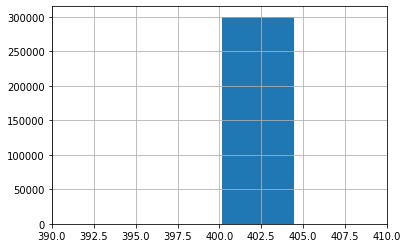

In [39]:
ax = bedfile.length.hist(bins=100)
ax.set_xlim(390, 410)

In [46]:
len(bedfile[bedfile.length == 404])

299961

The majority of peaks are of 404 bp long, the maximal length being 551 bp.

In [49]:
for i in range(1, 22):
    print('number of peaks on chromosome {}: {}'.format(i, len(bedfile[bedfile.chrom == 'chr' + str(i)])))

number of peaks on chromosome 1: 33264
number of peaks on chromosome 2: 23056
number of peaks on chromosome 3: 16904
number of peaks on chromosome 4: 16387
number of peaks on chromosome 5: 18490
number of peaks on chromosome 6: 21000
number of peaks on chromosome 7: 22871
number of peaks on chromosome 8: 13834
number of peaks on chromosome 9: 10067
number of peaks on chromosome 10: 13201
number of peaks on chromosome 11: 15203
number of peaks on chromosome 12: 12347
number of peaks on chromosome 13: 4693
number of peaks on chromosome 14: 5367
number of peaks on chromosome 15: 8144
number of peaks on chromosome 16: 11585
number of peaks on chromosome 17: 11829
number of peaks on chromosome 18: 6147
number of peaks on chromosome 19: 12005
number of peaks on chromosome 20: 6855
number of peaks on chromosome 21: 5179


#### Creating a 1D convolutional classifier

The model takes one-hot-encoded DNA window of 551 bp long as input and classify them between being a binding site or not.

In [4]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(551, 4)))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Creating the generator to train the network

The model is fed with a `Generator` instance. The DNA sequence is passed through the fasta file, the positions of binding site are passed through the bed file, we need to precise the batch size and finally that we are predicting binding site.

In this exemple, we will train the network on the first five chromosomes, we precise:
- the output shape as it is not standard, keyword output_shape
- the length of input DNA window, keyword seq_len
- the negative ratio to its default value of 1, keyword negative_ratio

Note that the length of the input can be set to the maximal length encounter by specifying seq_len='MAXLEN' (default behaviour), but it will be the maximal length in the 5 first chromosomes.

In [5]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=551,
                            negative_ratio=1,
                            output_shape=(64, 1))

We create a `ModelWrapper` instance to associate the model to its `Generator` instance, train and evaluate the model.

In [6]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr6', 'chr7'])

In [14]:
wrap.train(epochs=3)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
3378/3378 [==============================] - 224s 66ms/step - loss: 0.5986 - accuracy: 0.6543 - val_loss: 0.5912 - val_accuracy: 0.6691
Epoch 2/3
3378/3378 [==============================] - 211s 62ms/step - loss: 0.5847 - accuracy: 0.6690 - val_loss: 0.6050 - val_accuracy: 0.6459
Epoch 3/3
3378/3378 [==============================] - 211s 62ms/step - loss: 0.5756 - accuracy: 0.6755 - val_loss: 0.5861 - val_accuracy: 0.6706


In [20]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

432/432 [==============================] - 20s 47ms/step - loss: 0.5892 - accuracy: 0.6690


[0.5891944118258026, 0.6689815]

To evaluate the acuracy of our binding site detector at a chromosome scale, we calculate the AUROC on all the available data on a chromosome. We can choose to either consider one positive example per binding site or to apply data augmentation (all the window containing a whole binding site will be considered as positive example). Negative examples are every windows whitout having any intersection with positive examples.

In [7]:
wrap.get_auc(incl_chromosomes=['chr8'], data_augmentation=False, verbose=1)

This evaluation can be made on another species if we pass the DNA sequence through a fasta file, and the annotation file. As an example we use the human genome as if it was a new species. We will calculate the area under Precision-Recall curve in this example.

In [9]:
wrap.get_auc(incl_chromosomes=['chr8'],
             fasta_file='hg38.fa',
             data_augmentation=False,
             annotation_files=['taf15.bed'],
             curve='PR',
             verbose=1)

432/432 [==============================] - 25s 57ms/step - loss: 0.6990 - auc_3: 0.4918


[{'cell_idx': 0, 'annotation': 'binding site', 'AUPR': 0.49177095}]

With our detector in hand we can predict the presence of binding site along a chromosome. To do so we use the method `predict`. As we saw in the regression section we need to pass the chromosome size as arguments.

In [8]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes

--2020-05-08 11:12:22--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 11672 (11K) [text/plain]
Sauvegarde en : « hg38.chrom.sizes »

hg38.chrom.sizes    100%[===================>]  11.40K  --.-KB/s    ds 0s      

2020-05-08 11:12:23 (117 MB/s) — « hg38.chrom.sizes » sauvegardé [11672/11672]



In [8]:
prediction = wrap.predict(incl_chromosomes=['chr8'],
                          chrom_size='hg38.chrom.sizes',
                          export_to_path='taf15_prediction.bw',
                          verbose=1)

50/50 [==============================] - 3s 56ms/step


#### Training with random negative example

We can train our model with random sequence as negative exemple, it may be useful as a first easy training before reusing the network to train it with the real problem.

One need to specify ```negative_type = 'random'```

In [8]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=551,
                            negative_ratio=1,
                            negative_type='random',
                            output_shape=(64, 1))

In [9]:
wrap = ModelWrapper(model=model,
                   generator_train=generator_train,
                   validation_chr=['chr6', 'chr7'])

In [10]:
wrap.train(epochs=1)

3378/3378 [==============================] - 280s 83ms/step - loss: 0.0268 - accuracy: 0.9888 - val_loss: 0.0036 - val_accuracy: 0.9989


#### Data Augmentation

Background sequences are far more numerous than binding site. To mitigate this fact one can apply a data-augmentation procedure. Here, we will use an input window of 414 bp (10 bp more than the majority of positive sequence) and apply data-augmentation. All the sequences of length 414 bp containing a binding site will be considered as positive exemples (it multiplies roughly the number of positives examples by 10), longer sequences will be cut.

In [3]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(414, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=414,
                            negative_ratio=1,
                            data_augmentation=True,
                            output_shape=(64, 1))

In [9]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr6', 'chr7'])

In [11]:
wrap.train(epochs=1)

In [ ]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

## Precisely predict the position of binding site whitin a sequence

We can also try to set precisely the position of binding site within sequences that contain one. To do so we will train a seq2seq model and limit the training data to positive examples. We will apply a data augmentation strategy to gain more data.

The model takes input of 416 bp long and return an output of the same size with 1 where the binding sites are and 0 elsewhere.

In [10]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 1), activation='relu', padding='same', input_shape=(416, 4, 1)))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2D(32, (10, 1), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2D(64, (20, 1), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2DTranspose(64, (20, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2DTranspose(32, (10, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2DTranspose(16, (3, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2D(1, (1, 4), activation='sigmoid', padding='valid'))
model.add(keras.layers.Reshape((416, 1)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We create an adapted `Generator` instance. First notice that we set seq2seq to True to specify that we will train a seq2seq model. The negative example are discarted by setting negative_type to None. As the model is now a 2D convolutional network we add a final dummy axis to the input (dummy_axis=2). The standard output shape is (batch_size, output_length, # cellular type, # annotation to predict at the same time), here (64, 416, 1, 1), we remove one dummy axis by specifying output_shape=(64, 416, 1).

In [24]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq2seq=True,
                            data_augmentation=True,
                            defined_positive='match_any',
                            seq_len=416,
                            dummy_axis=2,
                            negative_type=None,
                            output_shape=(64, 416, 1))

In [25]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr6', 'chr7'])

In [27]:
wrap.train(epochs=1)

In [ ]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

## Label shape and functionnalities

In this section, we different classification problem and how one can the create corresponding  `Generator` instances.

- #### Predicting the same annotation on different cellular type:

Imagine the ChIP-seq peak data in two different cell types and we want to classify if a sequence is a peak of ChIP-seq in both callular type. We will just copy our data to use it as an example.

In [39]:
!cp taf15.bed taf15_heart.bed

In [40]:
Generator.predict_label_shape(batch_size=64,
                              fasta_file='hg38.fa',
                              annotation_files=['taf15.bed', 'taf15_heart.bed'],
                              annotation_list=['binding site'],
                              incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                              seq2seq=False,
                              data_augmentation=False,
                              defined_positive='match_any',
                              seq_len=404,
                              negative_type=None)

(2, 1)

The standard output shape is (2, 1) corresponding to (nb_cellular_type, nb_annotation).


- #### Positioning precisely ChIP-seq peaks in two cellular type:

Now let's say we want to precisely set where the peaks are in both cell type. Let's change seq_len and turn seq2seq to True.

In [41]:
Generator.predict_label_shape(batch_size=64,
                              fasta_file='hg38.fa',
                              annotation_files=['taf15.bed', 'taf15_heart.bed'],
                              annotation_list=['binding site'],
                              incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                              seq2seq=True,
                              data_augmentation=False,
                              defined_positive='match_any',
                              seq_len=420,
                              negative_type=None)

(420, 2, 1)

The standard output shape correspond to (length_of_input, nb_cellular_type, nb_annotation).

- #### Predicting several annotation at the same time:

We will classify here sequences as begining of a gene, begining of a pseudogene or background. Note that the gff file is the format adapted to this task as a bed file contains only one kind of annotation.

In [28]:
! wget ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.39_GRCh38.p13/GCF_000001405.39_GRCh38.p13_genomic.gff.gz
! gunzip GCF_000001405.39_GRCh38.p13_genomic.gff.gz

### Replace the NCBI chromosome name by a simpler
! perl -pe 's/NC_000001.11/chr1/g' GCF_000001405.39_GRCh38.p13_genomic.gff > hg38_gene.gff

--2020-07-23 15:10:24--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.39_GRCh38.p13/GCF_000001405.39_GRCh38.p13_genomic.gff.gz
           => « GCF_000001405.39_GRCh38.p13_genomic.gff.gz »
Résolution de ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)… 130.14.250.11, 2607:f220:41e:250::11, 2607:f220:41e:250::12, ...
Connexion à ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:21… connecté.
Ouverture de session en tant que anonymous… Session établie.
==> SYST ... terminé.    ==> PWD ... terminé.
==> TYPE I ... terminé.  ==> CWD (1) /genomes/all/GCF/000/001/405/GCF_000001405.39_GRCh38.p13 ... terminé.
==> SIZE GCF_000001405.39_GRCh38.p13_genomic.gff.gz ... 49043324
==> PASV ... terminé.    ==> RETR GCF_000001405.39_GRCh38.p13_genomic.gff.gz ... terminé.
Taille : 49043324 (47M) (non certifiée)

GCF_000001405.39_GR 100%[===================>]  46.77M  13.8MB/s    ds 3.9s    

2020-07-23 15:10:29 (12.1 MB/s) - « GCF_000001405.39_GRCh38.p13_genomic.gff.gz » sauvega

To create a `Generator` instance that yield the DNA sequence around the start of an annotation example, set predict='start'.

In [38]:
Generator.predict_label_shape(batch_size=64,
                              fasta_file='hg38.fa',
                              annotation_files=['hg38_gene.gff'],
                              annotation_list=['gene', 'pseudogene'],
                              incl_chromosomes=['chr1'],
                              seq2seq=False,
                              data_augmentation=False,
                              seq_len=299,
                              predict='start')

(1, 2)

Here we see that the standard format is (number of cell type = number of gff file passed, number of annotation).

## Classification and regression simultaneously

In this section, we will use a CNN network to predict both if a sequence is binding site and the nucleosome coverage on the sequence.

First, let's download a bigwig file containing the nucleosome coverage on the human genome.

In [40]:
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Homo_sapiens/bySample/hsNuc0010101/Homo_sapiens.hsNuc0010101.nucleosome.shift.bw
!mv Homo_sapiens.hsNuc0010101.nucleosome.shift.bw homo_sapiens.bw

--2020-07-23 16:02:02--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Homo_sapiens/bySample/hsNuc0010101/Homo_sapiens.hsNuc0010101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 349021252 (333M) [text/plain]
Sauvegarde en : « Homo_sapiens.hsNuc0010101.nucleosome.shift.bw »

Homo_sapiens.hsNuc0 100%[===================>] 332.85M  4.31MB/s    ds 2m 39s  

2020-07-23 16:04:42 (2.09 MB/s) — « Homo_sapiens.hsNuc0010101.nucleosome.shift.bw » sauvegardé [349021252/349021252]



Then we create a CNN that takes the DNA sequence one-hot-encoded as input and returns a classification between being a binding site and the nucleosome density covering the DNA sequence.

In [4]:
dna_extractor = keras.models.Sequential()

dna_extractor.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(404, 4)))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(32, 10, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(64, 20, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Flatten())

dna_inputs = keras.layers.Input(shape=(404, 4))

dna_features = dna_extractor(dna_inputs)

output_classifier = keras.layers.Dense(1, activation='sigmoid')(dna_features)
output_density = keras.layers.Dense(404, activation='linear')(dna_features)

model = keras.models.Model(dna_inputs, [output_classifier, output_density])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam')

Now, we use the sec_input keyword to create a `Generetor` instance that yields two labels at the same time.

In [5]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1'],
                            seq_len=404,
                            negative_ratio=1,
                            negative_type='real',
                            output_shape=(64, 1),
                            sec_inputs=['homo_sapiens.bw'],
                            sec_input_length=404,
                            sec_input_shape=(64, 404),
                            sec_normalization_mode=['max', 'perctrim'],
                            use_sec_as='targets')

In [7]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train)

wrap.train(epochs=1)

## Multi Genome training

To train our network we use the hg38 genome in the direct strand. As an exemple of training a network on several genome at the same time we will use hg38 in the direct strand and hg38 in the reverse strand.

Note that the procedure is the same if we want to train a network on several genome at the same time (several species, assembly). In particular we use `SeqIntervalDl` and `MultiGenerator`.

In [28]:
from keras_dna import SeqIntervalDl, MultiGenerator

In [32]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(551, 4)))
model.add(keras.layers.MaxPooling1D(2))
dna_input
model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We prepare one `SeqIntervalDl` instance in the direct strand and another in the reverse one. They are associated in a `MultiGenerator` instance.

In [33]:
dataset_direct = SeqIntervalDl(fasta_file='hg38.fa',
                                annotation_files=['taf15.bed'],
                                annotation_list=['binding site'],
                                incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                                seq_len=551,
                                negative_ratio=1,
                                negative_type='real')

dataset_reversed = SeqIntervalDl(fasta_file='hg38.fa',
                                  annotation_files=['taf15.bed'],
                                  annotation_list=['binding site'],
                                  incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                                  seq_len=551,
                                  negative_ratio=1,
                                  rc=True,
                                  negative_type='real')

generator_train = MultiGenerator(batch_size=64,
                                 dataset_list=[dataset_direct, dataset_reversed])

We can now create a `ModelWrapper` instance and train it as usual.

In [35]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train)

wrap.train(epochs=1)

Then we want to evaluate the prediction in the direct strand. As we used a `MultiGenerator` instance, we need to precise both the fasta file and the annotation file in the `get_auc` method.

In [42]:
wrap.get_auc(incl_chromosomes=['chr8'],
             data_augmentation=True,
             fasta_file='hg38.fa',
             annotation_files=['taf15.bed'],
             verbose=1)

The same apply for prediction, the fasta file need to be precised. Here we set rc to True in order to predict in the reverse strand.

In [40]:
wrap.predict(incl_chromosomes=['chr8'],
             chrom_size='hg38.chrom.sizes',
             fasta_file='hg38.fa',
             rc=True,
             verbose=1)